#  Tutorial:RNA+ATAC (no label)

In this tutorial, we will show how to cluster RNA+ATAC(no labeled) data using scMAGCA. As an example, we use a human peripheral blood mononuclear sample dataset 'GSM4949911' containing 8213 cells with two omics. Among them, ATAC has 66828 features and RNA containis 36601 features.

## Loading package

In [17]:
import numpy as np
import pandas as pd
import torch
import scanpy as sc
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
from scMAGCA.preprocess import read_dataset, preprocess_dataset
from scMAGCA.utils import *
from scMAGCA.scMAGCA import scMultiCluster

In [3]:
# set seed
random.seed(3407)
np.random.seed(3407)
torch.manual_seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.enabled = False
torch.backends.cudnn.benchmark = False

## Reading dataset

The required input files include: 
1) x1: Chromatin accessibility matrix (data format is h5ad file) : GSM4949911_tea_atac.h5ad;\
2) x2: Gene expression matrix (data format is h5ad file) : GSM4949911_tea_rna.h5ad.

To ensure reproducibility of the results, please read the above data as follows:

In [4]:
x1 = np.array(sc.read_h5ad('../datasets/GSM4949911/GSM4949911_atac.h5ad').to_df()).astype('float32')
x2 = np.array(sc.read_h5ad('../datasets/GSM4949911/GSM4949911_rna.h5ad').to_df()).astype('float32')
y = None

In [5]:
x1,x2

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32))

We select the two omics data for high expression, and the number of chosen features are both set to 2000.

Chosen offset: 1.24
Chosen offset: 0.33


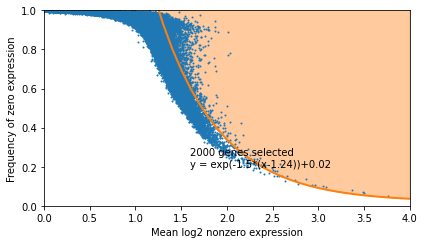

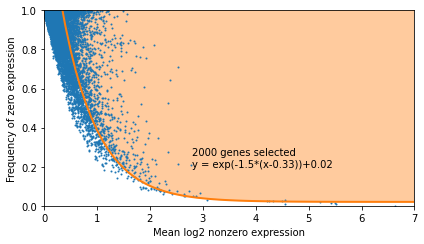

In [6]:
importantGenes = geneSelection(x1, n=2000)
x1 = x1[:, importantGenes]
importantGenes = geneSelection(x2, n=2000)
x2 = x2[:, importantGenes]

In [7]:
adata1 = sc.AnnData(x1)
adata1 = read_dataset(adata1, copy=True)
adata1 = preprocess_dataset(adata1, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 2000 features and 8213 cells.


In [8]:
adata1

AnnData object with n_obs × n_vars = 8213 × 2000
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

In [9]:
adata2 = sc.AnnData(x2)
adata2 = read_dataset(adata2, copy=True)
adata2 = preprocess_dataset(adata2, normalize_input=True, logtrans_input=True)

### Autoencoder: Successfully preprocessed 2000 features and 8213 cells.


In [10]:
adata2

AnnData object with n_obs × n_vars = 8213 × 2000
    obs: 'DCA_split', 'size_factors'
    var: 'mean', 'std'
    uns: 'log1p'

## Training the model

In [11]:
model = scMultiCluster(input_dim1=adata1.n_vars,input_dim2=adata2.n_vars,
                       alpha=0.2,beta=0.8,gama=0.01,device='cuda').to('cuda')

In [12]:
model

scMultiCluster(
  (encoder): Encoder(
    (stacked_gnn): ModuleList(
      (0): GCNConv(4000, 1024)
      (1): GCNConv(1024, 256)
      (2): GCNConv(256, 64)
      (3): GCNConv(64, 32)
    )
    (stacked_bns): ModuleList(
      (0): BatchNorm1d(1024, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (2): BatchNorm1d(64, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
      (3): BatchNorm1d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
    )
    (stacked_prelus): ModuleList(
      (0-3): 4 x PReLU(num_parameters=1)
    )
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): PReLU(num_parameters=1)
    (3): Linear(in_features=512, out_features=1024, bias=True)
    (4): BatchNorm1d(1024, eps=1e-05, moment

The ad_out parameter is set to 32 in the RNA+ATAC dataset.

In [13]:
pretrain_latent = model.pretrain_autoencoder(
                        X1=adata1.X, X2=adata2.X, X1_raw=adata1.raw.X, X2_raw=adata2.raw.X, 
                        epochs=400, file='GSM4949911',ad_out=32)

Pretraining stage
Pretrain epoch 1, recon_loss:1.177419, zinb_loss:0.945166, adversial_loss:1.372231
Pretrain epoch 2, recon_loss:1.087229, zinb_loss:0.921236, adversial_loss:1.373194
Pretrain epoch 3, recon_loss:0.948224, zinb_loss:0.890657, adversial_loss:1.373617
Pretrain epoch 4, recon_loss:0.885800, zinb_loss:0.858559, adversial_loss:1.358683
Pretrain epoch 5, recon_loss:0.866452, zinb_loss:0.824501, adversial_loss:1.359133
Pretrain epoch 6, recon_loss:0.856318, zinb_loss:0.789515, adversial_loss:1.355022
Pretrain epoch 7, recon_loss:0.850889, zinb_loss:0.759701, adversial_loss:1.351529
Pretrain epoch 8, recon_loss:0.842909, zinb_loss:0.738662, adversial_loss:1.351824
Pretrain epoch 9, recon_loss:0.836522, zinb_loss:0.726100, adversial_loss:1.351907
Pretrain epoch 10, recon_loss:0.829639, zinb_loss:0.718908, adversial_loss:1.350247
Pretrain epoch 11, recon_loss:0.824786, zinb_loss:0.713263, adversial_loss:1.348227
Pretrain epoch 12, recon_loss:0.821581, zinb_loss:0.707017, adversi

Pretrain epoch 100, recon_loss:0.773266, zinb_loss:0.631716, adversial_loss:1.305090
Pretrain epoch 101, recon_loss:0.773141, zinb_loss:0.631620, adversial_loss:1.305019
Pretrain epoch 102, recon_loss:0.772991, zinb_loss:0.631532, adversial_loss:1.304864
Pretrain epoch 103, recon_loss:0.772879, zinb_loss:0.631514, adversial_loss:1.303902
Pretrain epoch 104, recon_loss:0.772725, zinb_loss:0.631433, adversial_loss:1.304510
Pretrain epoch 105, recon_loss:0.772648, zinb_loss:0.631401, adversial_loss:1.303271
Pretrain epoch 106, recon_loss:0.772535, zinb_loss:0.631453, adversial_loss:1.303749
Pretrain epoch 107, recon_loss:0.772562, zinb_loss:0.631585, adversial_loss:1.302562
Pretrain epoch 108, recon_loss:0.772743, zinb_loss:0.631804, adversial_loss:1.303632
Pretrain epoch 109, recon_loss:0.773139, zinb_loss:0.632166, adversial_loss:1.301710
Pretrain epoch 110, recon_loss:0.772615, zinb_loss:0.631620, adversial_loss:1.302210
Pretrain epoch 111, recon_loss:0.772099, zinb_loss:0.631244, adve

Pretrain epoch 198, recon_loss:0.761929, zinb_loss:0.626830, adversial_loss:1.276672
Pretrain epoch 199, recon_loss:0.761676, zinb_loss:0.626703, adversial_loss:1.276777
Pretrain epoch 200, recon_loss:0.761598, zinb_loss:0.626732, adversial_loss:1.276787
Pretrain epoch 201, recon_loss:0.761551, zinb_loss:0.626729, adversial_loss:1.276282
Pretrain epoch 202, recon_loss:0.761438, zinb_loss:0.626608, adversial_loss:1.275815
Pretrain epoch 203, recon_loss:0.761329, zinb_loss:0.626583, adversial_loss:1.276529
Pretrain epoch 204, recon_loss:0.761202, zinb_loss:0.626573, adversial_loss:1.275519
Pretrain epoch 205, recon_loss:0.761257, zinb_loss:0.626585, adversial_loss:1.275652
Pretrain epoch 206, recon_loss:0.761152, zinb_loss:0.626577, adversial_loss:1.275099
Pretrain epoch 207, recon_loss:0.761234, zinb_loss:0.626690, adversial_loss:1.275626
Pretrain epoch 208, recon_loss:0.761665, zinb_loss:0.627107, adversial_loss:1.273614
Pretrain epoch 209, recon_loss:0.761999, zinb_loss:0.627263, adve

Pretrain epoch 296, recon_loss:0.752381, zinb_loss:0.624503, adversial_loss:1.258430
Pretrain epoch 297, recon_loss:0.752095, zinb_loss:0.624473, adversial_loss:1.258393
Pretrain epoch 298, recon_loss:0.752020, zinb_loss:0.624451, adversial_loss:1.258269
Pretrain epoch 299, recon_loss:0.751884, zinb_loss:0.624454, adversial_loss:1.257985
Pretrain epoch 300, recon_loss:0.751720, zinb_loss:0.624407, adversial_loss:1.257759
Pretrain epoch 301, recon_loss:0.751619, zinb_loss:0.624393, adversial_loss:1.257720
Pretrain epoch 302, recon_loss:0.751603, zinb_loss:0.624389, adversial_loss:1.257465
Pretrain epoch 303, recon_loss:0.751616, zinb_loss:0.624417, adversial_loss:1.257201
Pretrain epoch 304, recon_loss:0.751976, zinb_loss:0.624573, adversial_loss:1.257134
Pretrain epoch 305, recon_loss:0.753156, zinb_loss:0.625050, adversial_loss:1.257288
Pretrain epoch 306, recon_loss:0.754855, zinb_loss:0.625786, adversial_loss:1.256867
Pretrain epoch 307, recon_loss:0.754816, zinb_loss:0.626012, adve

Pretrain epoch 394, recon_loss:0.742424, zinb_loss:0.623246, adversial_loss:1.243256
Pretrain epoch 395, recon_loss:0.741983, zinb_loss:0.623228, adversial_loss:1.243176
Pretrain epoch 396, recon_loss:0.741756, zinb_loss:0.623253, adversial_loss:1.243132
Pretrain epoch 397, recon_loss:0.742005, zinb_loss:0.623249, adversial_loss:1.242527
Pretrain epoch 398, recon_loss:0.742020, zinb_loss:0.623239, adversial_loss:1.243070
Pretrain epoch 399, recon_loss:0.742514, zinb_loss:0.623436, adversial_loss:1.241964
Pretrain epoch 400, recon_loss:0.743174, zinb_loss:0.623717, adversial_loss:1.243144


When the parameter n_cluster is set to -1, scMAGCA will use GetCluster to estimate the number of clusters according to the resolution parameter and the potential representation obtained by pre-training, and use ASW, DB index and CH value to evaluate the clustering results. 

In [14]:
y_pred, final_latent = model.fit(y=y, n_clusters=-1, num_epochs=2000, file='GSM4949911', 
                                 pretrain_latent=pretrain_latent, resolution=0.1)

Clustering stage
Estimated n_clusters is:  6
Initializing cluster centers with kmeans.
Initializing k-means: ASW= 0.4081, DB= 0.9771, CH= 4057.4425
Training epoch 1, recon_loss:0.744567, zinb_loss:0.624116, cluster_loss:0.184134
Clustering   1: ASW= 0.4081, DB= 0.9771, CH= 4057.4425
Training epoch 2, recon_loss:0.781684, zinb_loss:0.635306, cluster_loss:0.192307
Clustering   2: ASW= 0.5035, DB= 0.7872, CH= 7048.4868
Training epoch 3, recon_loss:0.781879, zinb_loss:0.638056, cluster_loss:0.199501
Clustering   3: ASW= 0.5203, DB= 0.7576, CH= 7181.4846
Training epoch 4, recon_loss:0.802478, zinb_loss:0.644835, cluster_loss:0.204655
Clustering   4: ASW= 0.5511, DB= 0.7052, CH= 9237.8673
Training epoch 5, recon_loss:0.788960, zinb_loss:0.637543, cluster_loss:0.195610
Clustering   5: ASW= 0.5629, DB= 0.6762, CH= 9559.8021
Training epoch 6, recon_loss:0.791756, zinb_loss:0.640890, cluster_loss:0.195503
Clustering   6: ASW= 0.5875, DB= 0.6388, CH= 10485.6587
Training epoch 7, recon_loss:0.7881

Training epoch 60, recon_loss:0.793047, zinb_loss:0.647811, cluster_loss:0.168048
Clustering   60: ASW= 0.7478, DB= 0.3540, CH= 26001.7672
Training epoch 61, recon_loss:0.792132, zinb_loss:0.647105, cluster_loss:0.168134
Clustering   61: ASW= 0.7472, DB= 0.3569, CH= 25502.1591
Training epoch 62, recon_loss:0.793054, zinb_loss:0.647648, cluster_loss:0.167881
Clustering   62: ASW= 0.7493, DB= 0.3515, CH= 26258.3489
Training epoch 63, recon_loss:0.792143, zinb_loss:0.647033, cluster_loss:0.167827
Clustering   63: ASW= 0.7487, DB= 0.3546, CH= 25811.4141
Training epoch 64, recon_loss:0.792888, zinb_loss:0.647470, cluster_loss:0.167610
Clustering   64: ASW= 0.7508, DB= 0.3495, CH= 26516.5546
Training epoch 65, recon_loss:0.791956, zinb_loss:0.646935, cluster_loss:0.167434
Clustering   65: ASW= 0.7502, DB= 0.3524, CH= 26101.7202
Training epoch 66, recon_loss:0.792565, zinb_loss:0.647317, cluster_loss:0.167206
Clustering   66: ASW= 0.7521, DB= 0.3474, CH= 26784.6218
Training epoch 67, recon_lo

Training epoch 119, recon_loss:0.792284, zinb_loss:0.647676, cluster_loss:0.162608
Clustering   119: ASW= 0.7748, DB= 0.3152, CH= 31723.7642
Training epoch 120, recon_loss:0.791855, zinb_loss:0.647488, cluster_loss:0.162505
Clustering   120: ASW= 0.7733, DB= 0.3188, CH= 32136.3572
Training epoch 121, recon_loss:0.792293, zinb_loss:0.647569, cluster_loss:0.162416
Clustering   121: ASW= 0.7750, DB= 0.3149, CH= 31745.1165
Training epoch 122, recon_loss:0.792150, zinb_loss:0.647669, cluster_loss:0.162275
Clustering   122: ASW= 0.7742, DB= 0.3166, CH= 32380.2880
Training epoch 123, recon_loss:0.792139, zinb_loss:0.647593, cluster_loss:0.162282
Clustering   123: ASW= 0.7750, DB= 0.3147, CH= 31769.1720
Training epoch 124, recon_loss:0.792110, zinb_loss:0.647936, cluster_loss:0.162088
Clustering   124: ASW= 0.7750, DB= 0.3154, CH= 32595.3393
Training epoch 125, recon_loss:0.791530, zinb_loss:0.647629, cluster_loss:0.162002
Clustering   125: ASW= 0.7752, DB= 0.3141, CH= 31880.2922
Training epoc

Training epoch 178, recon_loss:0.790610, zinb_loss:0.648408, cluster_loss:0.159975
Clustering   178: ASW= 0.7844, DB= 0.3010, CH= 34942.9135
Training epoch 179, recon_loss:0.790428, zinb_loss:0.648308, cluster_loss:0.160384
Clustering   179: ASW= 0.7840, DB= 0.3003, CH= 35323.6997
Training epoch 180, recon_loss:0.790463, zinb_loss:0.648340, cluster_loss:0.160018
Clustering   180: ASW= 0.7846, DB= 0.3009, CH= 35017.0617
Training epoch 181, recon_loss:0.789932, zinb_loss:0.648164, cluster_loss:0.160367
Clustering   181: ASW= 0.7842, DB= 0.3002, CH= 35387.8759
Training epoch 182, recon_loss:0.789944, zinb_loss:0.648180, cluster_loss:0.160067
Clustering   182: ASW= 0.7849, DB= 0.3004, CH= 35101.0235
Training epoch 183, recon_loss:0.789397, zinb_loss:0.648016, cluster_loss:0.160332
Clustering   183: ASW= 0.7844, DB= 0.3004, CH= 35452.8007
Training epoch 184, recon_loss:0.789369, zinb_loss:0.648022, cluster_loss:0.160072
Clustering   184: ASW= 0.7852, DB= 0.2998, CH= 35199.1717
Training epoc

Training epoch 237, recon_loss:0.788512, zinb_loss:0.647421, cluster_loss:0.158794
Clustering   237: ASW= 0.7910, DB= 0.2885, CH= 37468.2002
Training epoch 238, recon_loss:0.788288, zinb_loss:0.647432, cluster_loss:0.158921
Clustering   238: ASW= 0.7900, DB= 0.2906, CH= 37013.7336
Training epoch 239, recon_loss:0.787527, zinb_loss:0.647129, cluster_loss:0.158382
Clustering   239: ASW= 0.7910, DB= 0.2882, CH= 37499.3674
Training epoch 240, recon_loss:0.787364, zinb_loss:0.647135, cluster_loss:0.158593
Clustering   240: ASW= 0.7904, DB= 0.2899, CH= 37140.7009
Training epoch 241, recon_loss:0.786973, zinb_loss:0.646926, cluster_loss:0.158108
Clustering   241: ASW= 0.7911, DB= 0.2887, CH= 37554.2132
Training epoch 242, recon_loss:0.786919, zinb_loss:0.646965, cluster_loss:0.158426
Clustering   242: ASW= 0.7909, DB= 0.2894, CH= 37275.9489
Training epoch 243, recon_loss:0.786982, zinb_loss:0.646846, cluster_loss:0.158012
Clustering   243: ASW= 0.7910, DB= 0.2889, CH= 37611.8044
Training epoc

Training epoch 296, recon_loss:0.784774, zinb_loss:0.647065, cluster_loss:0.157790
Clustering   296: ASW= 0.7958, DB= 0.2818, CH= 39031.8003
Training epoch 297, recon_loss:0.784628, zinb_loss:0.646877, cluster_loss:0.157712
Clustering   297: ASW= 0.7968, DB= 0.2810, CH= 39346.3105
Training epoch 298, recon_loss:0.784813, zinb_loss:0.647039, cluster_loss:0.157856
Clustering   298: ASW= 0.7958, DB= 0.2814, CH= 39075.4216
Training epoch 299, recon_loss:0.784744, zinb_loss:0.646857, cluster_loss:0.157740
Clustering   299: ASW= 0.7971, DB= 0.2805, CH= 39409.4129
Training epoch 300, recon_loss:0.784963, zinb_loss:0.647021, cluster_loss:0.157959
Clustering   300: ASW= 0.7958, DB= 0.2809, CH= 39105.4821
Training epoch 301, recon_loss:0.784951, zinb_loss:0.646833, cluster_loss:0.157789
Clustering   301: ASW= 0.7973, DB= 0.2801, CH= 39453.4958
Training epoch 302, recon_loss:0.785138, zinb_loss:0.646986, cluster_loss:0.158054
Clustering   302: ASW= 0.7957, DB= 0.2801, CH= 39148.1492
Training epoc

Training epoch 355, recon_loss:0.783435, zinb_loss:0.645735, cluster_loss:0.156861
Clustering   355: ASW= 0.8013, DB= 0.2754, CH= 40868.4653
Training epoch 356, recon_loss:0.783249, zinb_loss:0.645768, cluster_loss:0.156935
Clustering   356: ASW= 0.7996, DB= 0.2753, CH= 40612.2424
Training epoch 357, recon_loss:0.783817, zinb_loss:0.645836, cluster_loss:0.156846
Clustering   357: ASW= 0.8015, DB= 0.2749, CH= 40919.6528
Training epoch 358, recon_loss:0.783946, zinb_loss:0.645938, cluster_loss:0.156968
Clustering   358: ASW= 0.7997, DB= 0.2752, CH= 40670.7753
Training epoch 359, recon_loss:0.784643, zinb_loss:0.646123, cluster_loss:0.156934
Clustering   359: ASW= 0.8016, DB= 0.2745, CH= 40952.6551
Training epoch 360, recon_loss:0.785131, zinb_loss:0.646333, cluster_loss:0.157133
Clustering   360: ASW= 0.7997, DB= 0.2753, CH= 40709.6457
Training epoch 361, recon_loss:0.785187, zinb_loss:0.646537, cluster_loss:0.157089
Clustering   361: ASW= 0.8017, DB= 0.2741, CH= 40957.8316
Training epoc

Training epoch 414, recon_loss:0.782210, zinb_loss:0.644979, cluster_loss:0.156436
Clustering   414: ASW= 0.8035, DB= 0.2709, CH= 42138.9944
Training epoch 415, recon_loss:0.782168, zinb_loss:0.645153, cluster_loss:0.156560
Clustering   415: ASW= 0.8041, DB= 0.2686, CH= 41862.9103
Training epoch 416, recon_loss:0.782156, zinb_loss:0.644922, cluster_loss:0.156448
Clustering   416: ASW= 0.8035, DB= 0.2707, CH= 42174.9479
Training epoch 417, recon_loss:0.782045, zinb_loss:0.645084, cluster_loss:0.156555
Clustering   417: ASW= 0.8041, DB= 0.2684, CH= 41912.7899
Training epoch 418, recon_loss:0.782157, zinb_loss:0.644887, cluster_loss:0.156476
Clustering   418: ASW= 0.8036, DB= 0.2706, CH= 42212.3904
Training epoch 419, recon_loss:0.782355, zinb_loss:0.645083, cluster_loss:0.156609
Clustering   419: ASW= 0.8041, DB= 0.2681, CH= 41932.8975
Training epoch 420, recon_loss:0.782541, zinb_loss:0.644936, cluster_loss:0.156559
Clustering   420: ASW= 0.8037, DB= 0.2705, CH= 42242.9432
Training epoc

Training epoch 473, recon_loss:0.782769, zinb_loss:0.645017, cluster_loss:0.156714
Clustering   473: ASW= 0.8058, DB= 0.2670, CH= 42854.1509
Training epoch 474, recon_loss:0.782834, zinb_loss:0.644981, cluster_loss:0.157267
Clustering   474: ASW= 0.8062, DB= 0.2654, CH= 42676.7876
Training epoch 475, recon_loss:0.782649, zinb_loss:0.645059, cluster_loss:0.156579
Clustering   475: ASW= 0.8058, DB= 0.2667, CH= 42905.8273
Training epoch 476, recon_loss:0.782543, zinb_loss:0.645011, cluster_loss:0.157114
Clustering   476: ASW= 0.8062, DB= 0.2645, CH= 42656.7664
Training epoch 477, recon_loss:0.782328, zinb_loss:0.645115, cluster_loss:0.156375
Clustering   477: ASW= 0.8059, DB= 0.2669, CH= 42958.6983
Training epoch 478, recon_loss:0.782134, zinb_loss:0.645056, cluster_loss:0.156864
Clustering   478: ASW= 0.8065, DB= 0.2643, CH= 42694.5783
Training epoch 479, recon_loss:0.781886, zinb_loss:0.645164, cluster_loss:0.156161
Clustering   479: ASW= 0.8060, DB= 0.2670, CH= 43047.9461
Training epoc

Training epoch 532, recon_loss:0.781639, zinb_loss:0.644465, cluster_loss:0.156129
Clustering   532: ASW= 0.8074, DB= 0.2639, CH= 43786.8876
Training epoch 533, recon_loss:0.782126, zinb_loss:0.644795, cluster_loss:0.155941
Clustering   533: ASW= 0.8102, DB= 0.2606, CH= 44258.9145
Training epoch 534, recon_loss:0.781268, zinb_loss:0.644469, cluster_loss:0.156163
Clustering   534: ASW= 0.8072, DB= 0.2644, CH= 43786.2120
Training epoch 535, recon_loss:0.781620, zinb_loss:0.644782, cluster_loss:0.155873
Clustering   535: ASW= 0.8103, DB= 0.2605, CH= 44253.5166
Training epoch 536, recon_loss:0.780965, zinb_loss:0.644442, cluster_loss:0.156071
Clustering   536: ASW= 0.8072, DB= 0.2641, CH= 43828.0405
Training epoch 537, recon_loss:0.781209, zinb_loss:0.644735, cluster_loss:0.155799
Clustering   537: ASW= 0.8102, DB= 0.2605, CH= 44236.6775
Training epoch 538, recon_loss:0.780710, zinb_loss:0.644404, cluster_loss:0.155909
Clustering   538: ASW= 0.8074, DB= 0.2638, CH= 43926.4304
Training epoc

Training epoch 591, recon_loss:0.780172, zinb_loss:0.643955, cluster_loss:0.155839
Clustering   591: ASW= 0.8099, DB= 0.2585, CH= 44691.1306
Training epoch 592, recon_loss:0.780529, zinb_loss:0.644264, cluster_loss:0.155436
Clustering   592: ASW= 0.8127, DB= 0.2574, CH= 45350.0267
Training epoch 593, recon_loss:0.780281, zinb_loss:0.644100, cluster_loss:0.155915
Clustering   593: ASW= 0.8100, DB= 0.2579, CH= 44779.0745
Training epoch 594, recon_loss:0.780412, zinb_loss:0.644187, cluster_loss:0.155406
Clustering   594: ASW= 0.8124, DB= 0.2575, CH= 45275.9918
Training epoch 595, recon_loss:0.780148, zinb_loss:0.644089, cluster_loss:0.155744
Clustering   595: ASW= 0.8102, DB= 0.2576, CH= 44839.5361
Training epoch 596, recon_loss:0.780226, zinb_loss:0.644087, cluster_loss:0.155358
Clustering   596: ASW= 0.8122, DB= 0.2582, CH= 45228.0594
Training epoch 597, recon_loss:0.780186, zinb_loss:0.644096, cluster_loss:0.155618
Clustering   597: ASW= 0.8105, DB= 0.2573, CH= 44903.7156
Training epoc

Training epoch 650, recon_loss:0.778107, zinb_loss:0.643033, cluster_loss:0.155092
Clustering   650: ASW= 0.8122, DB= 0.2554, CH= 45924.6186
Training epoch 651, recon_loss:0.778690, zinb_loss:0.643006, cluster_loss:0.154796
Clustering   651: ASW= 0.8142, DB= 0.2552, CH= 46018.5789
Training epoch 652, recon_loss:0.778243, zinb_loss:0.643031, cluster_loss:0.155043
Clustering   652: ASW= 0.8124, DB= 0.2553, CH= 45964.8776
Training epoch 653, recon_loss:0.778872, zinb_loss:0.643057, cluster_loss:0.154833
Clustering   653: ASW= 0.8142, DB= 0.2555, CH= 46079.7586
Training epoch 654, recon_loss:0.778560, zinb_loss:0.643091, cluster_loss:0.155050
Clustering   654: ASW= 0.8125, DB= 0.2552, CH= 45989.8558
Training epoch 655, recon_loss:0.779242, zinb_loss:0.643167, cluster_loss:0.155024
Clustering   655: ASW= 0.8142, DB= 0.2551, CH= 46103.8140
Training epoch 656, recon_loss:0.779103, zinb_loss:0.643213, cluster_loss:0.155182
Clustering   656: ASW= 0.8125, DB= 0.2551, CH= 45961.2954
Training epoc

Training epoch 709, recon_loss:0.778074, zinb_loss:0.642790, cluster_loss:0.154725
Clustering   709: ASW= 0.8158, DB= 0.2530, CH= 46777.9486
Training epoch 710, recon_loss:0.777951, zinb_loss:0.642915, cluster_loss:0.154469
Clustering   710: ASW= 0.8150, DB= 0.2536, CH= 47345.5181
Training epoch 711, recon_loss:0.778174, zinb_loss:0.643005, cluster_loss:0.154892
Clustering   711: ASW= 0.8157, DB= 0.2529, CH= 46715.3361
Training epoch 712, recon_loss:0.778256, zinb_loss:0.643272, cluster_loss:0.154632
Clustering   712: ASW= 0.8152, DB= 0.2536, CH= 47443.6459
Training epoch 713, recon_loss:0.778531, zinb_loss:0.643366, cluster_loss:0.155186
Clustering   713: ASW= 0.8154, DB= 0.2533, CH= 46578.3952
Training epoch 714, recon_loss:0.778820, zinb_loss:0.643772, cluster_loss:0.154919
Clustering   714: ASW= 0.8152, DB= 0.2538, CH= 47489.9950
Training epoch 715, recon_loss:0.779109, zinb_loss:0.643819, cluster_loss:0.155592
Clustering   715: ASW= 0.8152, DB= 0.2524, CH= 46404.5132
Training epoc

Training epoch 768, recon_loss:0.777070, zinb_loss:0.642494, cluster_loss:0.154678
Clustering   768: ASW= 0.8160, DB= 0.2504, CH= 47496.6849
Training epoch 769, recon_loss:0.776925, zinb_loss:0.642351, cluster_loss:0.154852
Clustering   769: ASW= 0.8175, DB= 0.2519, CH= 47951.3571
Training epoch 770, recon_loss:0.777375, zinb_loss:0.642543, cluster_loss:0.154771
Clustering   770: ASW= 0.8162, DB= 0.2503, CH= 47494.7784
Training epoch 771, recon_loss:0.777223, zinb_loss:0.642378, cluster_loss:0.154939
Clustering   771: ASW= 0.8175, DB= 0.2517, CH= 47902.5939
Training epoch 772, recon_loss:0.777657, zinb_loss:0.642523, cluster_loss:0.154726
Clustering   772: ASW= 0.8163, DB= 0.2498, CH= 47455.9876
Training epoch 773, recon_loss:0.777357, zinb_loss:0.642314, cluster_loss:0.154855
Clustering   773: ASW= 0.8174, DB= 0.2517, CH= 47929.0949
Training epoch 774, recon_loss:0.777748, zinb_loss:0.642456, cluster_loss:0.154608
Clustering   774: ASW= 0.8167, DB= 0.2500, CH= 47466.7829
Training epoc

Training epoch 827, recon_loss:0.777959, zinb_loss:0.642427, cluster_loss:0.154883
Clustering   827: ASW= 0.8177, DB= 0.2507, CH= 47915.0480
Training epoch 828, recon_loss:0.777856, zinb_loss:0.642755, cluster_loss:0.154371
Clustering   828: ASW= 0.8188, DB= 0.2477, CH= 48821.8021
Training epoch 829, recon_loss:0.777135, zinb_loss:0.642103, cluster_loss:0.154636
Clustering   829: ASW= 0.8178, DB= 0.2504, CH= 48037.2285
Training epoch 830, recon_loss:0.777458, zinb_loss:0.642535, cluster_loss:0.154187
Clustering   830: ASW= 0.8189, DB= 0.2474, CH= 48886.5609
Training epoch 831, recon_loss:0.776849, zinb_loss:0.641941, cluster_loss:0.154521
Clustering   831: ASW= 0.8181, DB= 0.2506, CH= 48239.6799
Training epoch 832, recon_loss:0.777565, zinb_loss:0.642464, cluster_loss:0.154255
Clustering   832: ASW= 0.8187, DB= 0.2479, CH= 48836.7624
Training epoch 833, recon_loss:0.776898, zinb_loss:0.641913, cluster_loss:0.154519
Clustering   833: ASW= 0.8183, DB= 0.2507, CH= 48351.9679
Training epoc

Training epoch 886, recon_loss:0.776248, zinb_loss:0.641718, cluster_loss:0.153637
Clustering   886: ASW= 0.8203, DB= 0.2461, CH= 49586.6471
Training epoch 887, recon_loss:0.776062, zinb_loss:0.641394, cluster_loss:0.153757
Clustering   887: ASW= 0.8197, DB= 0.2482, CH= 49189.4583
Training epoch 888, recon_loss:0.776075, zinb_loss:0.641554, cluster_loss:0.153617
Clustering   888: ASW= 0.8201, DB= 0.2461, CH= 49618.5872
Training epoch 889, recon_loss:0.775857, zinb_loss:0.641287, cluster_loss:0.153741
Clustering   889: ASW= 0.8197, DB= 0.2483, CH= 49236.0970
Training epoch 890, recon_loss:0.775937, zinb_loss:0.641456, cluster_loss:0.153599
Clustering   890: ASW= 0.8202, DB= 0.2461, CH= 49685.8725
Training epoch 891, recon_loss:0.775771, zinb_loss:0.641211, cluster_loss:0.153749
Clustering   891: ASW= 0.8198, DB= 0.2477, CH= 49256.8575
Training epoch 892, recon_loss:0.776006, zinb_loss:0.641408, cluster_loss:0.153616
Clustering   892: ASW= 0.8203, DB= 0.2460, CH= 49729.4514
Training epoc

Training epoch 945, recon_loss:0.775697, zinb_loss:0.641373, cluster_loss:0.154116
Clustering   945: ASW= 0.8204, DB= 0.2462, CH= 49517.5703
Training epoch 946, recon_loss:0.775706, zinb_loss:0.641617, cluster_loss:0.153643
Clustering   946: ASW= 0.8223, DB= 0.2434, CH= 50452.5558
Training epoch 947, recon_loss:0.775548, zinb_loss:0.641124, cluster_loss:0.153979
Clustering   947: ASW= 0.8206, DB= 0.2460, CH= 49581.5547
Training epoch 948, recon_loss:0.775715, zinb_loss:0.641411, cluster_loss:0.153572
Clustering   948: ASW= 0.8223, DB= 0.2436, CH= 50440.3620
Training epoch 949, recon_loss:0.775554, zinb_loss:0.640954, cluster_loss:0.153866
Clustering   949: ASW= 0.8208, DB= 0.2456, CH= 49667.0371
Training epoch 950, recon_loss:0.775860, zinb_loss:0.641265, cluster_loss:0.153520
Clustering   950: ASW= 0.8222, DB= 0.2437, CH= 50460.8942
Training epoch 951, recon_loss:0.775514, zinb_loss:0.640827, cluster_loss:0.153793
Clustering   951: ASW= 0.8209, DB= 0.2460, CH= 49678.3158
Training epoc

Training epoch 1004, recon_loss:0.774872, zinb_loss:0.640223, cluster_loss:0.154007
Clustering   1004: ASW= 0.8225, DB= 0.2448, CH= 50373.5489
Training epoch 1005, recon_loss:0.775838, zinb_loss:0.640723, cluster_loss:0.153199
Clustering   1005: ASW= 0.8225, DB= 0.2425, CH= 50910.2397
Training epoch 1006, recon_loss:0.774710, zinb_loss:0.640018, cluster_loss:0.153908
Clustering   1006: ASW= 0.8223, DB= 0.2450, CH= 50386.1029
Training epoch 1007, recon_loss:0.775670, zinb_loss:0.640588, cluster_loss:0.153072
Clustering   1007: ASW= 0.8228, DB= 0.2423, CH= 50950.2659
Training epoch 1008, recon_loss:0.774410, zinb_loss:0.639877, cluster_loss:0.153721
Clustering   1008: ASW= 0.8224, DB= 0.2454, CH= 50523.0174
Training epoch 1009, recon_loss:0.775360, zinb_loss:0.640477, cluster_loss:0.152959
Clustering   1009: ASW= 0.8232, DB= 0.2420, CH= 51011.8464
Training epoch 1010, recon_loss:0.774118, zinb_loss:0.639831, cluster_loss:0.153528
Clustering   1010: ASW= 0.8224, DB= 0.2451, CH= 50669.9318

Training epoch 1062, recon_loss:0.774019, zinb_loss:0.640683, cluster_loss:0.153377
Clustering   1062: ASW= 0.8220, DB= 0.2417, CH= 50940.9325
Training epoch 1063, recon_loss:0.774221, zinb_loss:0.640612, cluster_loss:0.153107
Clustering   1063: ASW= 0.8240, DB= 0.2429, CH= 51431.4129
Training epoch 1064, recon_loss:0.774509, zinb_loss:0.640865, cluster_loss:0.153341
Clustering   1064: ASW= 0.8223, DB= 0.2406, CH= 51057.2812
Training epoch 1065, recon_loss:0.774559, zinb_loss:0.640687, cluster_loss:0.153104
Clustering   1065: ASW= 0.8239, DB= 0.2429, CH= 51534.6099
Training epoch 1066, recon_loss:0.774634, zinb_loss:0.640854, cluster_loss:0.153398
Clustering   1066: ASW= 0.8225, DB= 0.2410, CH= 50923.8774
Training epoch 1067, recon_loss:0.774593, zinb_loss:0.640601, cluster_loss:0.153095
Clustering   1067: ASW= 0.8235, DB= 0.2435, CH= 51388.3023
Training epoch 1068, recon_loss:0.774729, zinb_loss:0.640764, cluster_loss:0.153330
Clustering   1068: ASW= 0.8230, DB= 0.2399, CH= 51054.2692

Training epoch 1120, recon_loss:0.773992, zinb_loss:0.640414, cluster_loss:0.153438
Clustering   1120: ASW= 0.8254, DB= 0.2406, CH= 52084.5068
Training epoch 1121, recon_loss:0.774311, zinb_loss:0.640638, cluster_loss:0.153123
Clustering   1121: ASW= 0.8244, DB= 0.2392, CH= 51884.4798
Training epoch 1122, recon_loss:0.773832, zinb_loss:0.640374, cluster_loss:0.153533
Clustering   1122: ASW= 0.8250, DB= 0.2414, CH= 52085.3913
Training epoch 1123, recon_loss:0.774137, zinb_loss:0.640543, cluster_loss:0.153118
Clustering   1123: ASW= 0.8242, DB= 0.2389, CH= 51808.9576
Training epoch 1124, recon_loss:0.773502, zinb_loss:0.640161, cluster_loss:0.153528
Clustering   1124: ASW= 0.8249, DB= 0.2416, CH= 52095.1682
Training epoch 1125, recon_loss:0.773787, zinb_loss:0.640369, cluster_loss:0.153102
Clustering   1125: ASW= 0.8240, DB= 0.2388, CH= 51683.2277
Training epoch 1126, recon_loss:0.773275, zinb_loss:0.639947, cluster_loss:0.153599
Clustering   1126: ASW= 0.8247, DB= 0.2421, CH= 52004.1862

Training epoch 1178, recon_loss:0.773879, zinb_loss:0.639723, cluster_loss:0.153041
Clustering   1178: ASW= 0.8250, DB= 0.2410, CH= 51940.5408
Training epoch 1179, recon_loss:0.773628, zinb_loss:0.640301, cluster_loss:0.152513
Clustering   1179: ASW= 0.8255, DB= 0.2384, CH= 52565.1082
Training epoch 1180, recon_loss:0.773520, zinb_loss:0.639959, cluster_loss:0.152949
Clustering   1180: ASW= 0.8254, DB= 0.2406, CH= 52130.1792
Training epoch 1181, recon_loss:0.773253, zinb_loss:0.640443, cluster_loss:0.152514
Clustering   1181: ASW= 0.8257, DB= 0.2374, CH= 52714.9296
Training epoch 1182, recon_loss:0.773152, zinb_loss:0.640021, cluster_loss:0.152951
Clustering   1182: ASW= 0.8251, DB= 0.2408, CH= 52030.9084
Training epoch 1183, recon_loss:0.772849, zinb_loss:0.640276, cluster_loss:0.152601
Clustering   1183: ASW= 0.8253, DB= 0.2377, CH= 52599.8909
Training epoch 1184, recon_loss:0.772800, zinb_loss:0.640041, cluster_loss:0.152884
Clustering   1184: ASW= 0.8254, DB= 0.2405, CH= 52247.6021

Training epoch 1236, recon_loss:0.773905, zinb_loss:0.639551, cluster_loss:0.153211
Clustering   1236: ASW= 0.8267, DB= 0.2373, CH= 52404.9179
Training epoch 1237, recon_loss:0.773953, zinb_loss:0.639922, cluster_loss:0.152549
Clustering   1237: ASW= 0.8265, DB= 0.2382, CH= 53397.7540
Training epoch 1238, recon_loss:0.773323, zinb_loss:0.639355, cluster_loss:0.152972
Clustering   1238: ASW= 0.8270, DB= 0.2371, CH= 52532.7435
Training epoch 1239, recon_loss:0.774101, zinb_loss:0.639987, cluster_loss:0.152722
Clustering   1239: ASW= 0.8255, DB= 0.2386, CH= 53064.5111
Training epoch 1240, recon_loss:0.774628, zinb_loss:0.640008, cluster_loss:0.153295
Clustering   1240: ASW= 0.8260, DB= 0.2395, CH= 51811.1712
Training epoch 1241, recon_loss:0.773324, zinb_loss:0.639445, cluster_loss:0.152822
Clustering   1241: ASW= 0.8242, DB= 0.2426, CH= 52168.5521
Training epoch 1242, recon_loss:0.772676, zinb_loss:0.638777, cluster_loss:0.153262
Clustering   1242: ASW= 0.8255, DB= 0.2388, CH= 51957.5249

Training epoch 1294, recon_loss:0.772979, zinb_loss:0.639685, cluster_loss:0.152234
Clustering   1294: ASW= 0.8273, DB= 0.2355, CH= 53972.5431
Training epoch 1295, recon_loss:0.772866, zinb_loss:0.639509, cluster_loss:0.152482
Clustering   1295: ASW= 0.8270, DB= 0.2369, CH= 53299.0114
Training epoch 1296, recon_loss:0.773143, zinb_loss:0.639984, cluster_loss:0.152344
Clustering   1296: ASW= 0.8271, DB= 0.2361, CH= 53848.2824
Training epoch 1297, recon_loss:0.772974, zinb_loss:0.639883, cluster_loss:0.152628
Clustering   1297: ASW= 0.8271, DB= 0.2370, CH= 53315.5827
Training epoch 1298, recon_loss:0.773333, zinb_loss:0.640344, cluster_loss:0.152419
Clustering   1298: ASW= 0.8270, DB= 0.2363, CH= 53787.1338
Training epoch 1299, recon_loss:0.773021, zinb_loss:0.640223, cluster_loss:0.152656
Clustering   1299: ASW= 0.8273, DB= 0.2367, CH= 53401.7473
Training epoch 1300, recon_loss:0.773605, zinb_loss:0.640603, cluster_loss:0.152450
Clustering   1300: ASW= 0.8270, DB= 0.2362, CH= 53769.2998

Training epoch 1352, recon_loss:0.772381, zinb_loss:0.639551, cluster_loss:0.152765
Clustering   1352: ASW= 0.8287, DB= 0.2342, CH= 53831.7886
Training epoch 1353, recon_loss:0.772489, zinb_loss:0.639781, cluster_loss:0.152451
Clustering   1353: ASW= 0.8278, DB= 0.2364, CH= 54028.8505
Training epoch 1354, recon_loss:0.772211, zinb_loss:0.639389, cluster_loss:0.152781
Clustering   1354: ASW= 0.8286, DB= 0.2350, CH= 53883.4986
Training epoch 1355, recon_loss:0.772476, zinb_loss:0.639586, cluster_loss:0.152365
Clustering   1355: ASW= 0.8280, DB= 0.2358, CH= 54031.2378
Training epoch 1356, recon_loss:0.771945, zinb_loss:0.639173, cluster_loss:0.152677
Clustering   1356: ASW= 0.8288, DB= 0.2349, CH= 53970.0474
Training epoch 1357, recon_loss:0.772143, zinb_loss:0.639446, cluster_loss:0.152306
Clustering   1357: ASW= 0.8275, DB= 0.2358, CH= 53898.5450
Training epoch 1358, recon_loss:0.771996, zinb_loss:0.639219, cluster_loss:0.152726
Clustering   1358: ASW= 0.8289, DB= 0.2354, CH= 53885.0351

Training epoch 1410, recon_loss:0.771443, zinb_loss:0.639096, cluster_loss:0.152075
Clustering   1410: ASW= 0.8285, DB= 0.2334, CH= 54604.9031
Training epoch 1411, recon_loss:0.770890, zinb_loss:0.639158, cluster_loss:0.151716
Clustering   1411: ASW= 0.8294, DB= 0.2346, CH= 54706.4227
Training epoch 1412, recon_loss:0.771499, zinb_loss:0.639153, cluster_loss:0.152013
Clustering   1412: ASW= 0.8285, DB= 0.2333, CH= 54792.2556
Training epoch 1413, recon_loss:0.771085, zinb_loss:0.639050, cluster_loss:0.151885
Clustering   1413: ASW= 0.8291, DB= 0.2356, CH= 54561.7477
Training epoch 1414, recon_loss:0.771887, zinb_loss:0.639223, cluster_loss:0.152052
Clustering   1414: ASW= 0.8286, DB= 0.2328, CH= 54874.3752
Training epoch 1415, recon_loss:0.771371, zinb_loss:0.639026, cluster_loss:0.152114
Clustering   1415: ASW= 0.8288, DB= 0.2360, CH= 54453.4938
Training epoch 1416, recon_loss:0.772349, zinb_loss:0.639457, cluster_loss:0.152063
Clustering   1416: ASW= 0.8288, DB= 0.2322, CH= 54898.2272

Training epoch 1468, recon_loss:0.771728, zinb_loss:0.639071, cluster_loss:0.151544
Clustering   1468: ASW= 0.8306, DB= 0.2321, CH= 55166.5309
Training epoch 1469, recon_loss:0.771511, zinb_loss:0.638383, cluster_loss:0.151988
Clustering   1469: ASW= 0.8292, DB= 0.2354, CH= 54741.2045
Training epoch 1470, recon_loss:0.771677, zinb_loss:0.638753, cluster_loss:0.151469
Clustering   1470: ASW= 0.8307, DB= 0.2319, CH= 55269.0282
Training epoch 1471, recon_loss:0.771672, zinb_loss:0.638344, cluster_loss:0.151806
Clustering   1471: ASW= 0.8296, DB= 0.2348, CH= 55068.2689
Training epoch 1472, recon_loss:0.772098, zinb_loss:0.638704, cluster_loss:0.151551
Clustering   1472: ASW= 0.8307, DB= 0.2314, CH= 55320.1890
Training epoch 1473, recon_loss:0.772111, zinb_loss:0.638602, cluster_loss:0.151777
Clustering   1473: ASW= 0.8301, DB= 0.2344, CH= 55326.3990
Training epoch 1474, recon_loss:0.772626, zinb_loss:0.638941, cluster_loss:0.151835
Clustering   1474: ASW= 0.8304, DB= 0.2317, CH= 55192.0030

Training epoch 1526, recon_loss:0.771215, zinb_loss:0.637864, cluster_loss:0.152045
Clustering   1526: ASW= 0.8298, DB= 0.2321, CH= 55411.1288
Training epoch 1527, recon_loss:0.771298, zinb_loss:0.637991, cluster_loss:0.151889
Clustering   1527: ASW= 0.8314, DB= 0.2329, CH= 55413.0791
Training epoch 1528, recon_loss:0.770950, zinb_loss:0.638025, cluster_loss:0.151909
Clustering   1528: ASW= 0.8301, DB= 0.2320, CH= 55562.8749
Training epoch 1529, recon_loss:0.770981, zinb_loss:0.637977, cluster_loss:0.151831
Clustering   1529: ASW= 0.8312, DB= 0.2336, CH= 55465.9097
Training epoch 1530, recon_loss:0.770621, zinb_loss:0.638176, cluster_loss:0.151744
Clustering   1530: ASW= 0.8304, DB= 0.2318, CH= 55688.3857
Training epoch 1531, recon_loss:0.770783, zinb_loss:0.638020, cluster_loss:0.151758
Clustering   1531: ASW= 0.8310, DB= 0.2338, CH= 55535.5689
Training epoch 1532, recon_loss:0.770536, zinb_loss:0.638393, cluster_loss:0.151630
Clustering   1532: ASW= 0.8306, DB= 0.2316, CH= 55773.6534

Training epoch 1584, recon_loss:0.772544, zinb_loss:0.639764, cluster_loss:0.152314
Clustering   1584: ASW= 0.8297, DB= 0.2344, CH= 55777.6551
Training epoch 1585, recon_loss:0.772187, zinb_loss:0.639910, cluster_loss:0.152444
Clustering   1585: ASW= 0.8319, DB= 0.2304, CH= 54962.6357
Training epoch 1586, recon_loss:0.772646, zinb_loss:0.639876, cluster_loss:0.152833
Clustering   1586: ASW= 0.8287, DB= 0.2346, CH= 55096.5719
Training epoch 1587, recon_loss:0.774406, zinb_loss:0.640095, cluster_loss:0.153536
Clustering   1587: ASW= 0.8288, DB= 0.2349, CH= 53272.9338
Training epoch 1588, recon_loss:0.772588, zinb_loss:0.638809, cluster_loss:0.152257
Clustering   1588: ASW= 0.8292, DB= 0.2360, CH= 54339.3411
Training epoch 1589, recon_loss:0.771132, zinb_loss:0.638414, cluster_loss:0.152148
Clustering   1589: ASW= 0.8299, DB= 0.2329, CH= 54761.9965
Training epoch 1590, recon_loss:0.771052, zinb_loss:0.638576, cluster_loss:0.151766
Clustering   1590: ASW= 0.8306, DB= 0.2332, CH= 55340.8002

Training epoch 1642, recon_loss:0.771019, zinb_loss:0.637913, cluster_loss:0.151418
Clustering   1642: ASW= 0.8315, DB= 0.2307, CH= 56456.4862
Training epoch 1643, recon_loss:0.771226, zinb_loss:0.638253, cluster_loss:0.151690
Clustering   1643: ASW= 0.8315, DB= 0.2292, CH= 56001.4068
Training epoch 1644, recon_loss:0.771596, zinb_loss:0.637969, cluster_loss:0.151842
Clustering   1644: ASW= 0.8311, DB= 0.2320, CH= 56307.7916
Training epoch 1645, recon_loss:0.771955, zinb_loss:0.638502, cluster_loss:0.152037
Clustering   1645: ASW= 0.8314, DB= 0.2301, CH= 55545.5936
Training epoch 1646, recon_loss:0.771684, zinb_loss:0.637909, cluster_loss:0.152070
Clustering   1646: ASW= 0.8310, DB= 0.2332, CH= 56178.3783
Training epoch 1647, recon_loss:0.771474, zinb_loss:0.638323, cluster_loss:0.151933
Clustering   1647: ASW= 0.8318, DB= 0.2298, CH= 55575.0934
Training epoch 1648, recon_loss:0.770580, zinb_loss:0.637706, cluster_loss:0.151750
Clustering   1648: ASW= 0.8315, DB= 0.2328, CH= 56385.2826

Training epoch 1700, recon_loss:0.770634, zinb_loss:0.639445, cluster_loss:0.151503
Clustering   1700: ASW= 0.8332, DB= 0.2289, CH= 56669.0357
Training epoch 1701, recon_loss:0.770062, zinb_loss:0.639138, cluster_loss:0.151367
Clustering   1701: ASW= 0.8320, DB= 0.2313, CH= 56996.3163
Training epoch 1702, recon_loss:0.770829, zinb_loss:0.639356, cluster_loss:0.151424
Clustering   1702: ASW= 0.8332, DB= 0.2287, CH= 56650.1569
Training epoch 1703, recon_loss:0.769805, zinb_loss:0.638908, cluster_loss:0.151425
Clustering   1703: ASW= 0.8321, DB= 0.2312, CH= 57078.2940
Training epoch 1704, recon_loss:0.770250, zinb_loss:0.639028, cluster_loss:0.151342
Clustering   1704: ASW= 0.8334, DB= 0.2282, CH= 56793.4144
Training epoch 1705, recon_loss:0.769636, zinb_loss:0.638806, cluster_loss:0.151362
Clustering   1705: ASW= 0.8324, DB= 0.2308, CH= 57100.0732
Training epoch 1706, recon_loss:0.769985, zinb_loss:0.638849, cluster_loss:0.151314
Clustering   1706: ASW= 0.8331, DB= 0.2282, CH= 56880.8331

Training epoch 1758, recon_loss:0.770159, zinb_loss:0.638231, cluster_loss:0.151252
Clustering   1758: ASW= 0.8340, DB= 0.2270, CH= 57232.0298
Training epoch 1759, recon_loss:0.769833, zinb_loss:0.637822, cluster_loss:0.151714
Clustering   1759: ASW= 0.8326, DB= 0.2323, CH= 57053.3032
Training epoch 1760, recon_loss:0.770333, zinb_loss:0.638551, cluster_loss:0.151379
Clustering   1760: ASW= 0.8341, DB= 0.2268, CH= 57234.4912
Training epoch 1761, recon_loss:0.769898, zinb_loss:0.638173, cluster_loss:0.151759
Clustering   1761: ASW= 0.8323, DB= 0.2324, CH= 56976.8936
Training epoch 1762, recon_loss:0.770391, zinb_loss:0.639049, cluster_loss:0.151395
Clustering   1762: ASW= 0.8343, DB= 0.2267, CH= 57299.4520
Training epoch 1763, recon_loss:0.769949, zinb_loss:0.638796, cluster_loss:0.151667
Clustering   1763: ASW= 0.8323, DB= 0.2325, CH= 56973.2918
Training epoch 1764, recon_loss:0.770345, zinb_loss:0.639431, cluster_loss:0.151456
Clustering   1764: ASW= 0.8340, DB= 0.2266, CH= 57388.6577

Training epoch 1816, recon_loss:0.769861, zinb_loss:0.637810, cluster_loss:0.151534
Clustering   1816: ASW= 0.8335, DB= 0.2292, CH= 56828.4266
Training epoch 1817, recon_loss:0.769705, zinb_loss:0.638238, cluster_loss:0.150946
Clustering   1817: ASW= 0.8340, DB= 0.2279, CH= 58099.7173
Training epoch 1818, recon_loss:0.769549, zinb_loss:0.637877, cluster_loss:0.151508
Clustering   1818: ASW= 0.8335, DB= 0.2291, CH= 56873.1990
Training epoch 1819, recon_loss:0.769553, zinb_loss:0.638346, cluster_loss:0.150848
Clustering   1819: ASW= 0.8344, DB= 0.2279, CH= 58398.4806
Training epoch 1820, recon_loss:0.769627, zinb_loss:0.637922, cluster_loss:0.151640
Clustering   1820: ASW= 0.8333, DB= 0.2291, CH= 56766.2153
Training epoch 1821, recon_loss:0.769624, zinb_loss:0.638292, cluster_loss:0.150871
Clustering   1821: ASW= 0.8348, DB= 0.2280, CH= 58584.1731
Training epoch 1822, recon_loss:0.769789, zinb_loss:0.637743, cluster_loss:0.151807
Clustering   1822: ASW= 0.8332, DB= 0.2286, CH= 56668.2015

Training epoch 1874, recon_loss:0.769822, zinb_loss:0.638970, cluster_loss:0.151447
Clustering   1874: ASW= 0.8348, DB= 0.2276, CH= 57528.0434
Training epoch 1875, recon_loss:0.770381, zinb_loss:0.638312, cluster_loss:0.152162
Clustering   1875: ASW= 0.8327, DB= 0.2303, CH= 56815.9054
Training epoch 1876, recon_loss:0.769683, zinb_loss:0.639021, cluster_loss:0.151487
Clustering   1876: ASW= 0.8333, DB= 0.2305, CH= 57059.6606
Training epoch 1877, recon_loss:0.771052, zinb_loss:0.638785, cluster_loss:0.152958
Clustering   1877: ASW= 0.8322, DB= 0.2281, CH= 56177.8559
Training epoch 1878, recon_loss:0.770320, zinb_loss:0.639217, cluster_loss:0.151445
Clustering   1878: ASW= 0.8337, DB= 0.2297, CH= 57046.4740
Training epoch 1879, recon_loss:0.770510, zinb_loss:0.638672, cluster_loss:0.152240
Clustering   1879: ASW= 0.8330, DB= 0.2270, CH= 56694.2280
Training epoch 1880, recon_loss:0.769889, zinb_loss:0.639014, cluster_loss:0.151023
Clustering   1880: ASW= 0.8341, DB= 0.2285, CH= 57548.6577

Training epoch 1932, recon_loss:0.769345, zinb_loss:0.637183, cluster_loss:0.151275
Clustering   1932: ASW= 0.8337, DB= 0.2290, CH= 57940.4366
Training epoch 1933, recon_loss:0.769448, zinb_loss:0.637685, cluster_loss:0.150879
Clustering   1933: ASW= 0.8350, DB= 0.2265, CH= 57884.4448
Training epoch 1934, recon_loss:0.769667, zinb_loss:0.637067, cluster_loss:0.151962
Clustering   1934: ASW= 0.8329, DB= 0.2303, CH= 57138.2561
Training epoch 1935, recon_loss:0.769983, zinb_loss:0.637742, cluster_loss:0.151414
Clustering   1935: ASW= 0.8341, DB= 0.2278, CH= 56855.0262
Training epoch 1936, recon_loss:0.768838, zinb_loss:0.636645, cluster_loss:0.151873
Clustering   1936: ASW= 0.8331, DB= 0.2301, CH= 57009.0463
Training epoch 1937, recon_loss:0.768502, zinb_loss:0.637271, cluster_loss:0.150768
Clustering   1937: ASW= 0.8350, DB= 0.2267, CH= 57790.5302
Training epoch 1938, recon_loss:0.768035, zinb_loss:0.636544, cluster_loss:0.151435
Clustering   1938: ASW= 0.8341, DB= 0.2289, CH= 57499.0628

Training epoch 1990, recon_loss:0.769171, zinb_loss:0.638558, cluster_loss:0.150972
Clustering   1990: ASW= 0.8365, DB= 0.2245, CH= 58624.7474
Training epoch 1991, recon_loss:0.768784, zinb_loss:0.638496, cluster_loss:0.150656
Clustering   1991: ASW= 0.8353, DB= 0.2274, CH= 59176.4936
Training epoch 1992, recon_loss:0.769866, zinb_loss:0.638848, cluster_loss:0.150976
Clustering   1992: ASW= 0.8367, DB= 0.2238, CH= 58882.8603
Training epoch 1993, recon_loss:0.769482, zinb_loss:0.638755, cluster_loss:0.150743
Clustering   1993: ASW= 0.8351, DB= 0.2280, CH= 59055.9768
Training epoch 1994, recon_loss:0.770182, zinb_loss:0.639064, cluster_loss:0.150861
Clustering   1994: ASW= 0.8368, DB= 0.2241, CH= 58971.7132
Training epoch 1995, recon_loss:0.769485, zinb_loss:0.638650, cluster_loss:0.150787
Clustering   1995: ASW= 0.8352, DB= 0.2273, CH= 58983.8484
Training epoch 1996, recon_loss:0.770352, zinb_loss:0.638888, cluster_loss:0.150945
Clustering   1996: ASW= 0.8368, DB= 0.2240, CH= 59127.6146

In [16]:
import numpy as np

np.savetxt("../results/GSM4949911_pred.csv", y_pred, delimiter=",")
np.savetxt("../results/GSM4949911_embedding.csv", final_latent.cpu().detach().numpy(), delimiter=",")

In [13]:
library(anndata)
library(reticulate)
library(dplyr)
library(tidyr)
library(Seurat)
library(ggplot2)

In [17]:
use_condaenv("/home/zhouzeming/anaconda3")

In [18]:
sys <- import("sys")

In [19]:
ad <- import("anndata")

In [24]:
rna <- ad$read_h5ad('../datasets/GSM4949911/GSM4949911_rna.h5ad')
colnames(rna)[duplicated(colnames(rna))]
colnames(rna)<-make.unique(colnames(rna))
colnames(rna)[duplicated(colnames(rna))]
scRNA.rna <- rna$X

[1] "TBCE"           "LINC01238"      "CYB561D2"       "MATR3"         
 [5] "LINC01505"      "HSPA14"         "GOLGA8M"        "GGT1"          
 [9] "ARMCX5-GPRASP2" "TMSB15B"

Warning message in private$.anndata$obs_names$name <- attr(value, "name"):
“Coercing LHS to a list”
Warning message in private$.anndata$var_names$name <- attr(value, "name"):
“Coercing LHS to a list”


character(0)

In [27]:
scRNA <- CreateSeuratObject(counts = t(scRNA.rna),project ="scRNA",min.cells = 3)
label <- read.csv("../results/GSM4949911_pred.csv",header = F)
scRNA@meta.data$clusters <- label
Idents(scRNA) <- as.factor(label$V1)
scRNA <- NormalizeData(scRNA, normalization.method = "LogNormalize")
scRNA <- FindVariableFeatures(scRNA, selection.method = "vst", nfeatures = 2000) 
scRNA <- ScaleData(scRNA, features = rownames(scRNA))
all.genes <- rownames(scRNA)
variable.genes <- head(VariableFeatures(scRNA), 2000)

mds<- read.csv('../results/GSM4949911_embedding.csv',row.names=1)
mds <- as.matrix(mds)
colnames(mds) <- paste0("MDS_", 1:32)
scRNA[["mds"]] <- CreateDimReducObject(embeddings = mds, key = "MDS_", assay = DefaultAssay(scRNA))
scRNA <- RunUMAP(scRNA,dims = 1:30,label=T,reduction = "mds")

Warning message:
“Data is of class dgRMatrix. Coercing to dgCMatrix.”
Normalizing layer: counts

Finding variable features for layer counts

Centering and scaling data matrix

Warning message:
“The following arguments are not used: label”
Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
20:39:51 UMAP embedding parameters a = 0.9922 b = 1.112

20:39:51 Read 8213 rows and found 30 numeric columns

20:39:51 Using Annoy for neighbor search, n_neighbors = 30

20:39:51 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:39:52 Writing NN index 

In [28]:
scRNA.markers <- FindAllMarkers(scRNA, 
                                ident.col = "clusters",
                                only.pos = T,  
                                min.pct = 0.25, 
                                logfc.threshold = 0.25,
                                features = variable.genes)
top.markers <- scRNA.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC)

Calculating cluster 0

For a (much!) faster implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the presto package
--------------------------------------------
install.packages('devtools')
devtools::install_github('immunogenomics/presto')
--------------------------------------------
After installation of presto, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5



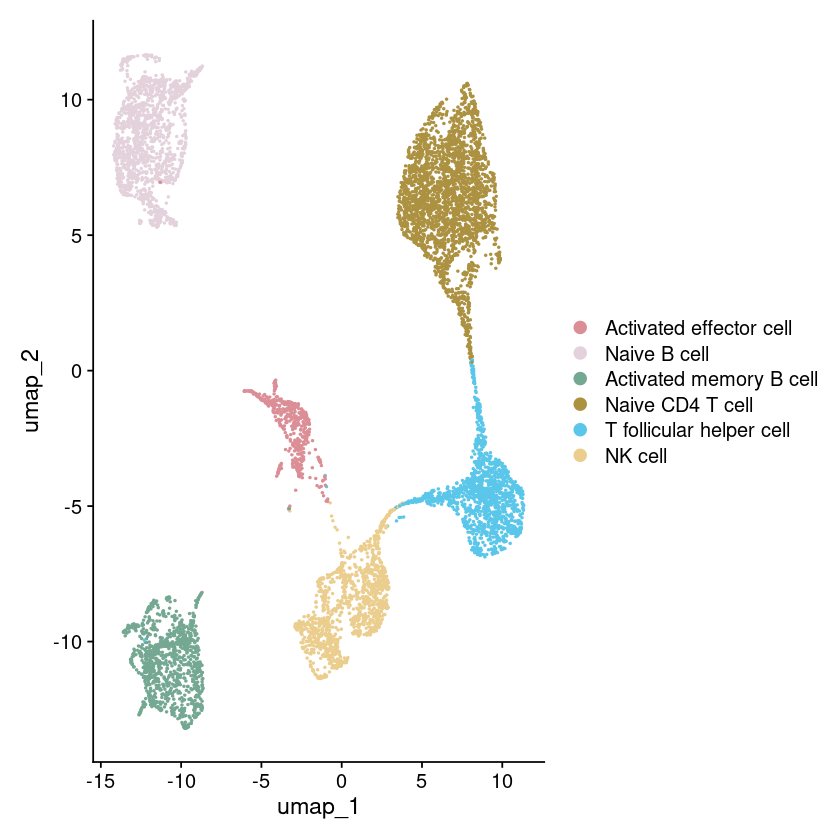

In [29]:
new.cluster.ids <- c("Activated effector cell", "Naive B cell", "Activated memory B cell", "Naive CD4 T cell", "T follicular helper cell", "NK cell")
mycolors <- c("Activated effector cell"='#dc8e97', "Naive B cell"='#e3d1db', "Activated memory B cell"='#74a893', "Naive CD4 T cell"='#ac9141', 
              "T follicular helper cell"='#5ac6e9', "NK cell"='#ebce8e')
names(new.cluster.ids) <- levels(scRNA)
scRNA <- RenameIdents(scRNA, new.cluster.ids)
Joint_umap <-DimPlot(scRNA, reduction = "umap", label = FALSE, cols = mycolors)
Joint_umap